In [3]:
import setpath
from prepare.show import get_material_dir
from run.start import get_device

import torch
from prepare.eegdataset import C_GeneralEEGImageDataset, GeneralEEGImageDataset, N2_GeneralEEGImageDataset

from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from run.others import SmallNet
from prepare.data import filter_two_samples
import run.resnet as resnet
import torch.nn as nn
data_path = '/data0/tianjunchao/dataset/CVPR2021-02785/data/img_pkl/32x32'

from utils.eegutils import getNow

dataset = C_GeneralEEGImageDataset(path=data_path, n_channels=1, grid_size=8, n_samples=1)
# dataset = get_test_setting(dataset)
train_loader = DataLoader(dataset, batch_size=8)
device = get_device()
material_dir = get_material_dir()

[6, 0, 0, 0, 0, 0, 0, 0]
device: cuda:1


resnet18
cur_epoch: 0, n_samples: 16
cur_epoch: 1, n_samples: 32
cur_epoch: 2, n_samples: 48
cur_epoch: 3, n_samples: 64
cur_epoch: 4, n_samples: 80
cur_epoch: 5, n_samples: 96
cur_epoch: 6, n_samples: 112
cur_epoch: 7, n_samples: 128
cur_epoch: 8, n_samples: 144
cur_epoch: 9, n_samples: 160
cur_epoch: 10, n_samples: 176
cur_epoch: 11, n_samples: 192
cur_epoch: 12, n_samples: 208
cur_epoch: 13, n_samples: 224
cur_epoch: 14, n_samples: 240
cur_epoch: 15, n_samples: 256
cur_epoch: 16, n_samples: 272
cur_epoch: 17, n_samples: 288
cur_epoch: 18, n_samples: 304
cur_epoch: 19, n_samples: 320
cur_epoch: 20, n_samples: 336
cur_epoch: 21, n_samples: 352
cur_epoch: 22, n_samples: 368
cur_epoch: 23, n_samples: 384
cur_epoch: 24, n_samples: 400
cur_epoch: 25, n_samples: 416
cur_epoch: 26, n_samples: 432
cur_epoch: 27, n_samples: 448
cur_epoch: 28, n_samples: 464
cur_epoch: 29, n_samples: 480
cur_epoch: 30, n_samples: 496
cur_epoch: 31, n_samples: 512
cur_epoch: 32, n_samples: 528
cur_epoch: 33, n_

/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


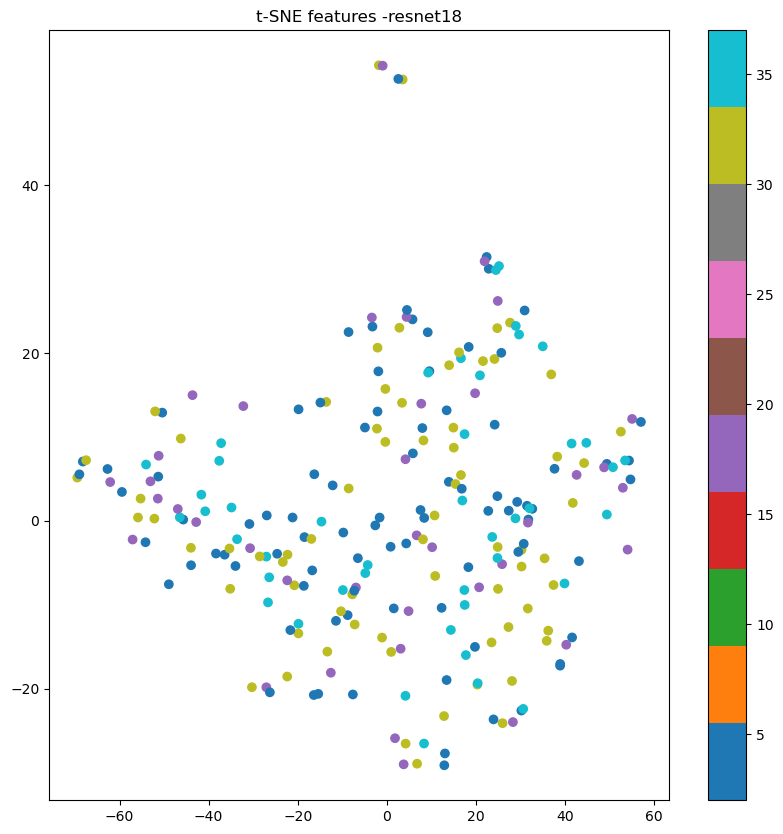

: 

In [22]:
# model_list = [resnet.resnet_name_A,resnet.resnet_name_B,resnet.resnet_name_C,resnet.resnet_name_D,resnet.resnet_name_E]
from prepare.show import get_tsne_features


model_list = [resnet.resnet_name_A]
# model_list = ['mobilenet_v2']
for model_name in model_list:
    if 'resnet' in model_name:
        model = resnet.ResNet(num_classes=40,model_name=model_name, pretrained=True).feature_extractor
    else:
        model = list(SmallNet().children())[0]

    # feature_extractor = nn.Sequential(*list(model.children())[:-1])
    
    # if 'mobilenet' in model_name:
    #     feature_extractor.add_module("AdaptiveAvgPool", nn.AdaptiveAvgPool2d(1))

    model = model.to(device)
    model.eval() 
    print(model_name)
    feature_stack = []
    label_stack = []
    target_n_samples = 2e3
    n_samples = 0
    cur_epoch = 0
    
    for i, (images, labels) in enumerate(train_loader):
        # 提取特征
        with torch.no_grad():
            for j in range(len(images)):
                input_data = images[j].to(device)
                emb = model(input_data).squeeze()
                feature_stack.append(emb)
                label_stack.append(labels)

        n_samples += len(labels)*len(images)
        print('cur_epoch: {}, n_samples: {}'.format(cur_epoch, n_samples))
        cur_epoch += 1
        if n_samples >= target_n_samples:
            break
        
    feature_list = torch.cat(feature_stack, dim=0)
    label_list = torch.cat(label_stack, dim=0)
    tsne_embs = get_tsne_features(feature_list.cpu().numpy())
    
    # 随机选10个类别画t-sne
    
    # 随机选10个类别来画t-sne
    unique_classes = np.unique(label_list)
    selected_classes = np.random.choice(unique_classes, 5, replace=False)

    # 仅选择选定类别的数据
    selected_data_indices = np.isin(label_list, selected_classes)
    tsne_embs = tsne_embs[selected_data_indices]
    selected_label_list = label_list[selected_data_indices]

    
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(tsne_embs[:, 0], tsne_embs[:, 1], c=selected_label_list, cmap='tab10')
    plt.colorbar()
    plt.title('t-SNE features -' + model_name)
    # plt.savefig(material_dir+ model_name+'tsne.png')
    # plt.close()
    plt.show()

In [20]:
 np.unique(selected_label_list)

array([ 0,  2, 10, 11, 12, 13, 18, 36, 37, 38])